In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

#plt.savefig('foo.png')

In [90]:
# Load the data CSV file (to get T_op)
low = "results_LOW.csv"  
res_low = pd.read_csv(low)

mid = "results_MID.csv" 
res_mid = pd.read_csv(mid)

top = "results_TOP.csv"  
res_top = pd.read_csv(top)

In [91]:
# Load the data CSV file (to get PMV)
pmv = "export.csv"  
pmv_index = pd.read_csv(pmv)

In [92]:
# create a column with averaged T_op
T_op = (
    res_low["T_OP"] + res_mid["T_OP"] + res_top["T_OP"]
) / 3
#print(T_op.max(),T_op.min())

In [93]:
# create a column with averaged T_mrt
T_mrt = (
    res_low["T_MRT"] + res_mid["T_MRT"] + res_top["T_MRT"]
) / 3
#print(T_mrt.max(),T_mrt.min())

In [94]:
# create a column with averaged Air_speed
Air_speed = (
    res_low["Air_speed"] + res_mid["Air_speed"] + res_top["Air_speed"]
) / 3

In [95]:
# Function to categories T_op

def categorize_T_op(value):
    if 21 <= value <= 22:
        return "Category IV"
    elif 22 < value <= 23:
        return "Category III"
    elif 23 < value <= 23.5:
        return "Category II"
    elif 23.5 < value <= 25.5:
        return "Category I"
    elif 25.5 < value <= 26:
        return "Category II"
    elif 26 < value <= 27:
        return "Category III"
    elif 27 < value <= 28:
        return "Category IV"
    elif value > 28 or value < 21:
        return "Beyond Category IV"
    else:
        return "Out of range"

In [96]:
T_op_category = T_op.apply(categorize_T_op)


In [97]:
#print(T_op_category.tail())
#print(T_op.tail())
#print(T_op_category.head())
#print(T_op.head())

In [98]:
# Step 1: Ensure datetime format
res_low["Date & Time"] = pd.to_datetime(res_low["Date & Time"])


In [99]:
# Step 2: Build a combined DataFrame using alignment
df = pd.DataFrame({
    "Date & Time": res_low["Date & Time"],
    "T_op": T_op,
    "pmv": pmv_index["pmv"],
    "ppd": pmv_index["ppd"],
    "Air_speed": Air_speed,
    "T_mrt": T_mrt   
})




In [100]:
# Step 3: Set datetime as index
df.set_index("Date & Time", inplace=True)

# Step 4: Average every minute
df_min = df.resample("1min").mean()




In [101]:
# Step 5: Average every 10 minutes

#Create a fixed 10-minute range starting at 09:15, 12 periods (12*10min = 2h)
start_time = pd.Timestamp("2025-03-14 09:15:00")
time_bins = pd.date_range(start=start_time, periods=13, freq="10min")

# Step 3: Assign each row to a bin
df["Time Step"] = pd.cut(df.index, bins=time_bins, labels=False, right=False)

# Step 4: Group by time step and average
df_10min = df.groupby("Time Step").mean()

# Add bin start time for better axis labels (e.g., 09:15, 09:25...)
df_10min["Start Time"] = time_bins[:-1].to_list()


In [102]:
print(df_min.head(), df_min.tail())
#print(df_10min)

                          T_op       pmv        ppd  Air_speed      T_mrt
Date & Time                                                              
2025-03-14 09:15:00  29.116465  1.264667  38.518333   0.066105  29.445007
2025-03-14 09:16:00  29.075069  1.240333  37.260000   0.077928  29.333660
2025-03-14 09:17:00  29.201732  1.312500  40.911667   0.054937  29.556109
2025-03-14 09:18:00  29.201355  1.284500  39.576667   0.074059  29.550515
2025-03-14 09:19:00  29.301372  1.344667  42.653333   0.050855  29.769454                           T_op       pmv        ppd  Air_speed      T_mrt
Date & Time                                                              
2025-03-14 11:11:00  20.503628 -2.970833  96.801667   0.583999  21.163463
2025-03-14 11:12:00  20.449408 -2.124500  81.663333   0.160171  20.801383
2025-03-14 11:13:00  20.452948 -2.050833  78.900000   0.136668  20.886923
2025-03-14 11:14:00  20.481492 -2.043000  78.535000   0.139794  21.064705
2025-03-14 11:15:00  20.603808 -1.9200

In [103]:
# Reset index to display or save
df_min = df_min.reset_index()
df_10min = df_10min.reset_index()
#print(df_10min)

In [104]:
T_op_category_10min = df_10min["T_op"].apply(categorize_T_op)
#print(T_op_category_10min.head(), T_op_category_10min.tail())
T_op_category_1min = df_min["T_op"].apply(categorize_T_op)

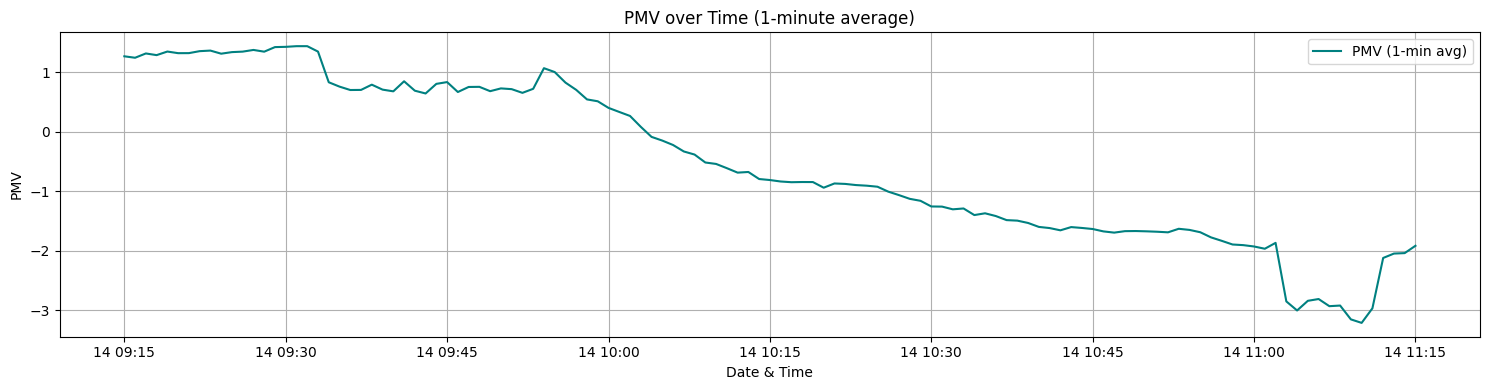

In [105]:
# pmv in function of time (1 min) USE THE ONE BELOW!!!
plt.figure(figsize=(15, 4))
plt.plot(df_min["Date & Time"], df_min["pmv"], label="PMV (1-min avg)", color="teal")
plt.xlabel("Date & Time")
plt.ylabel("PMV")
plt.title("PMV over Time (1-minute average)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


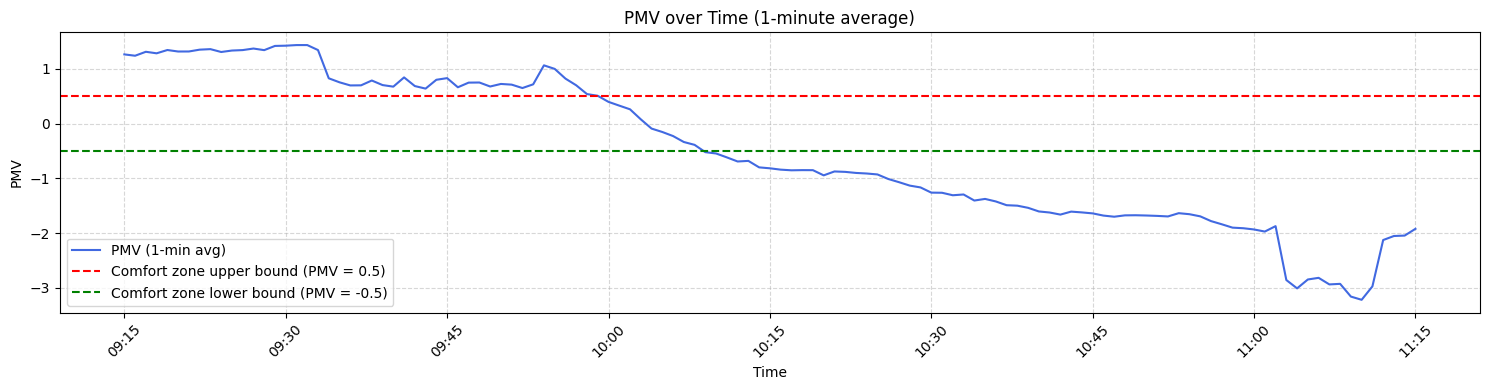

In [106]:
# pmv in function of time (1 min)
plt.figure(figsize=(15, 4))
plt.plot(df_min["Date & Time"], df_min["pmv"], label="PMV (1-min avg)", color="royalblue")
plt.axhline(y=0.5, color='red', linestyle='--', label="Comfort zone upper bound (PMV = 0.5)")
plt.axhline(y=-0.5, color='green', linestyle='--', label="Comfort zone lower bound (PMV = -0.5)")

plt.xlabel("Time")
plt.ylabel("PMV")
plt.title("PMV over Time (1-minute average)")
plt.xticks(rotation=45)
# Format x-axis to show only hours and minutes
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('pmv_1min.png')
plt.show()




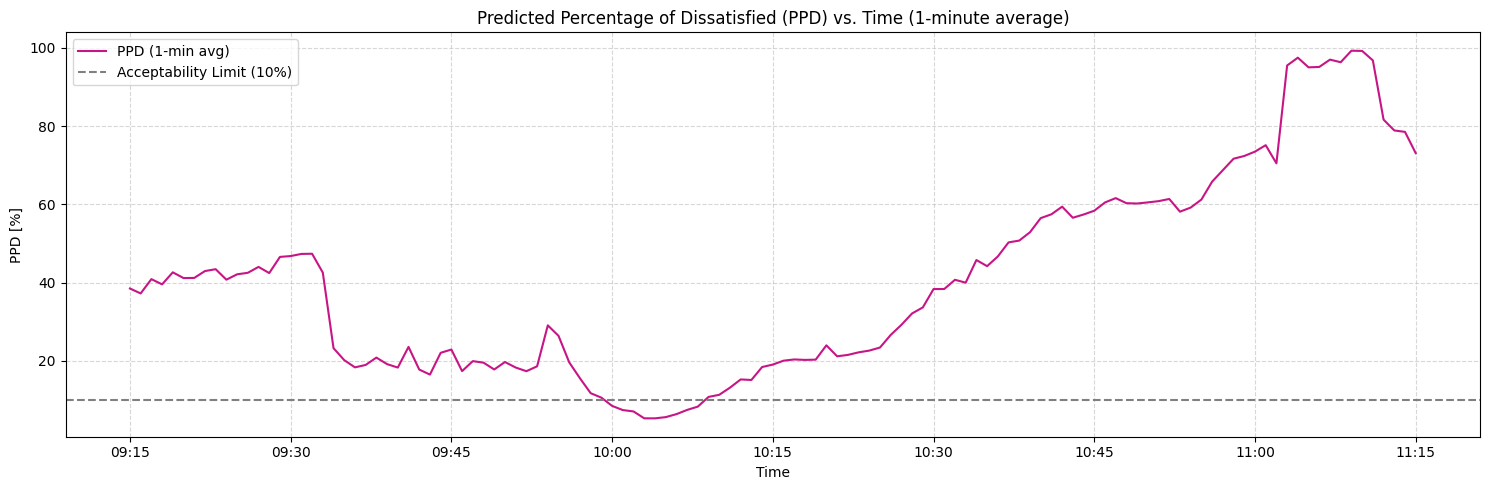

In [107]:
# Plot of ppd in function of time 1min average
plt.figure(figsize=(15, 5))

# Plot PPD over time
plt.plot(df_min["Date & Time"], df_min["ppd"], label="PPD (1-min avg)", color="mediumvioletred")

# Add horizontal line for acceptable limit
plt.axhline(y=10, color='gray', linestyle='--', label="Acceptability Limit (10%)")

# Format x-axis to show hours and minutes only
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Add labels and title
plt.xlabel("Time")
plt.ylabel("PPD [%]")
plt.title("Predicted Percentage of Dissatisfied (PPD) vs. Time (1-minute average)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('ppd_1min.png')
plt.show()


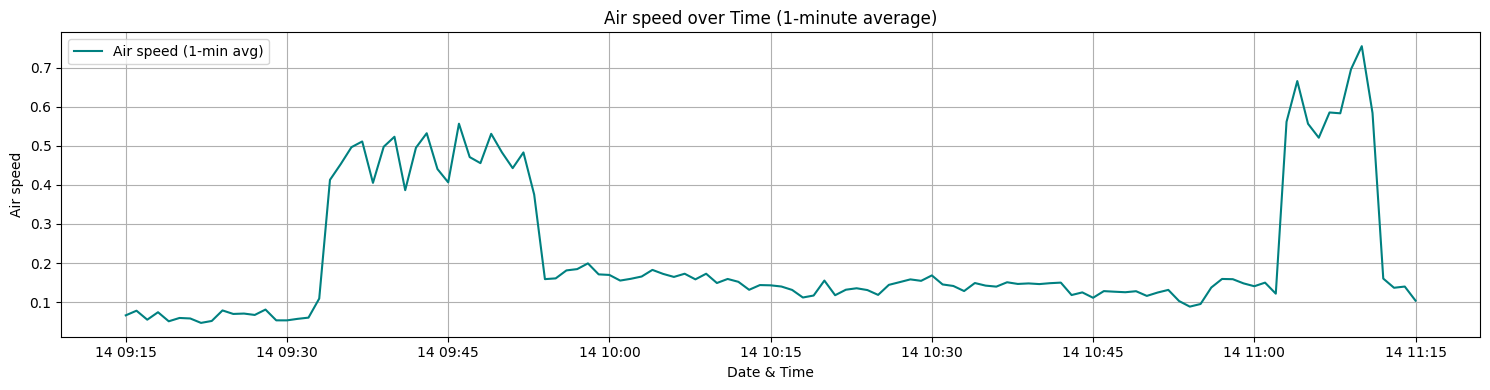

In [108]:
# plot air speed in function of time (to see if there is a big change between 11:00 and 11:15)

#USE THE ONE BELOW!!!
# Air speed in function of time (1 min)
plt.figure(figsize=(15, 4))
plt.plot(df_min["Date & Time"], df_min["Air_speed"], label="Air speed (1-min avg)", color="teal")
plt.xlabel("Date & Time")
plt.ylabel("Air speed")
plt.title("Air speed over Time (1-minute average)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


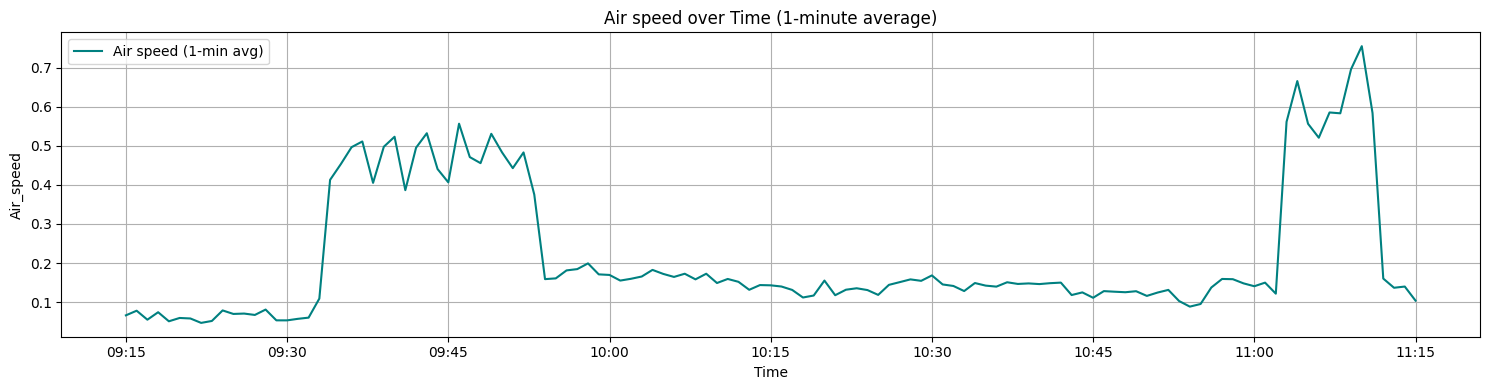

In [109]:
# Air speed in function of time (1 min)
plt.figure(figsize=(15, 4))
plt.plot(df_min["Date & Time"], df_min["Air_speed"], label="Air speed (1-min avg)", color="teal")

plt.xlabel("Time")
plt.ylabel("Air_speed")
plt.title("Air speed over Time (1-minute average)")

# Format x-axis to show only hours and minutes
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('airspeed_1min.png')
plt.show()


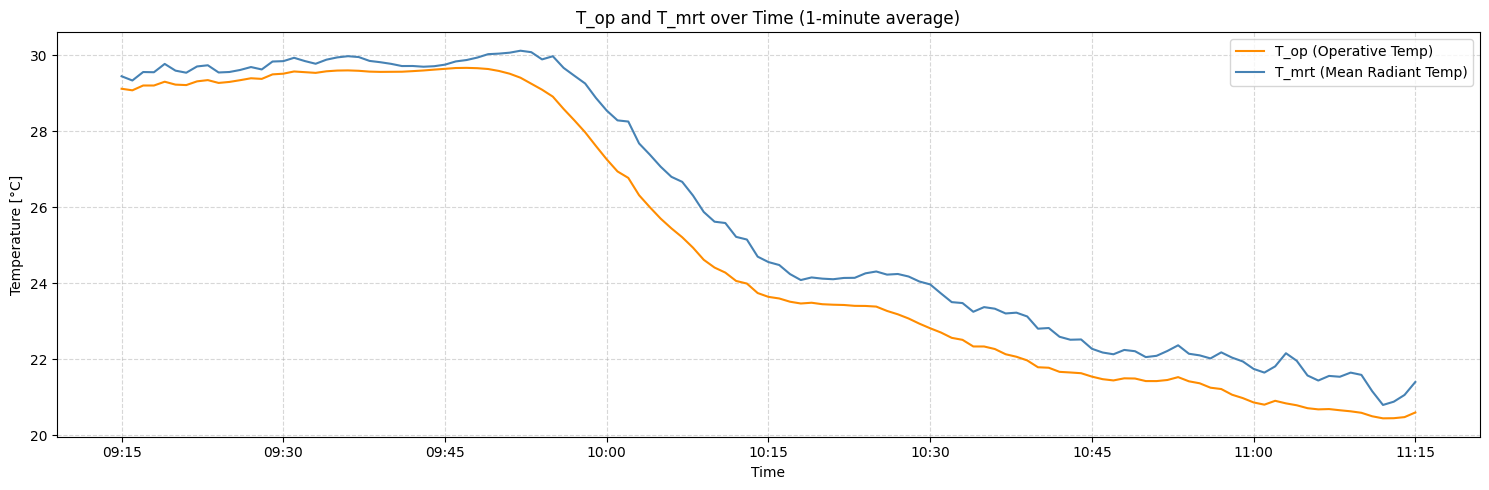

In [110]:
plt.figure(figsize=(15, 5))

# Plot T_op
plt.plot(df_min["Date & Time"], df_min["T_op"], label="T_op (Operative Temp)", color="darkorange")

# Plot T_mrt
plt.plot(df_min["Date & Time"], df_min["T_mrt"], label="T_mrt (Mean Radiant Temp)", color="steelblue")

# Time formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Labels and title
plt.xlabel("Time")
plt.ylabel("Temperature [°C]")
plt.title("T_op and T_mrt over Time (1-minute average)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('T_op_mrt_1min.png')
plt.show()

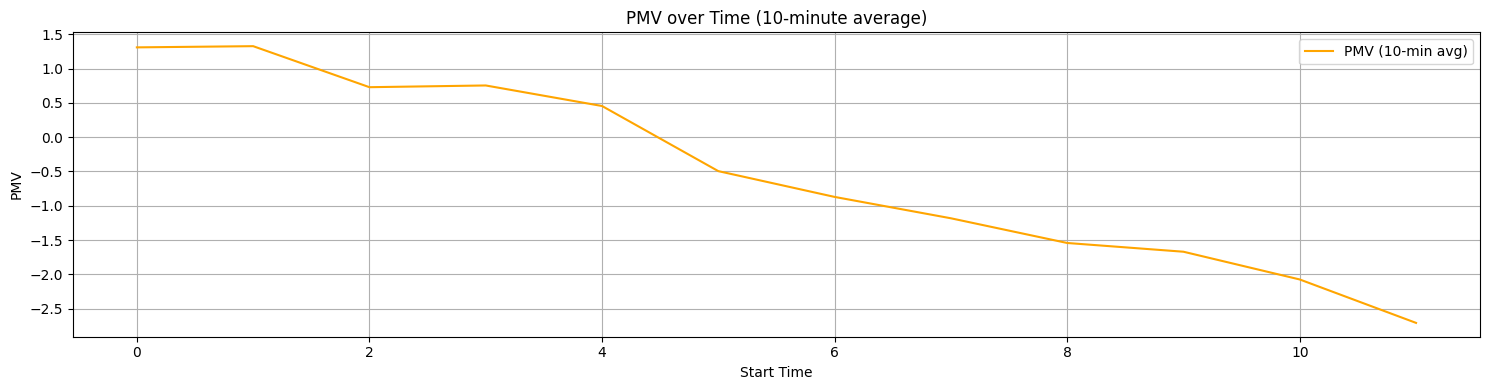

In [111]:
# pmv in function of time (10 min)
plt.figure(figsize=(15, 4))
plt.plot(df_10min["Time Step"], df_10min["pmv"], label="PMV (10-min avg)", color="orange")
plt.xlabel("Start Time")
plt.ylabel("PMV")
plt.title("PMV over Time (10-minute average)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

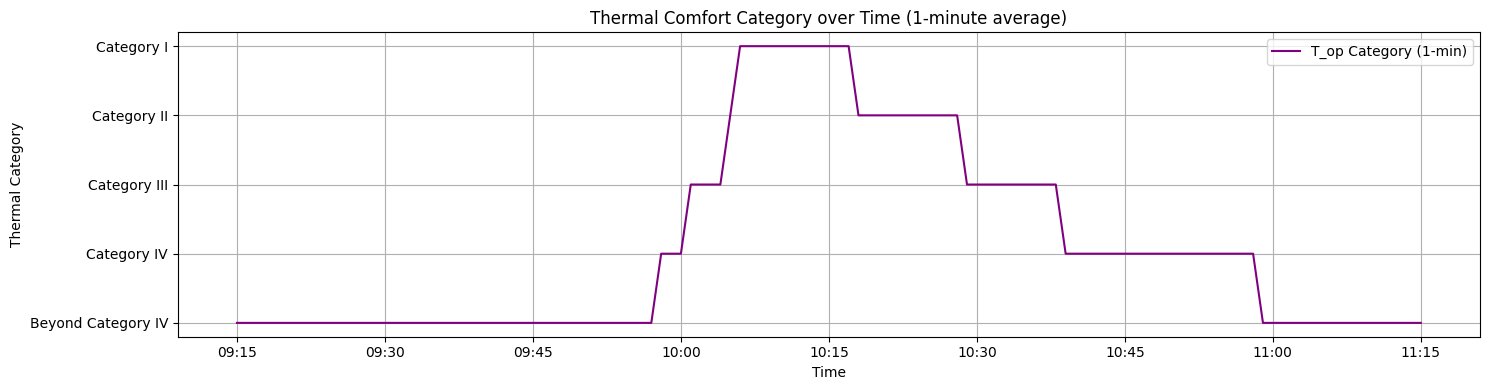

In [112]:
# T_op category vs time (1 min)
plt.figure(figsize=(15, 4))
plt.plot(df_min["Date & Time"], T_op_category_1min, label="T_op Category (1-min)", color="purple")
plt.xlabel("Time")
plt.ylabel("Thermal Category")
plt.title("Thermal Comfort Category over Time (1-minute average)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('cat_1min.png')
plt.show()


In [114]:
# Count minutes in each T_op category
top_category_counts = T_op_category_1min.value_counts().sort_index()

# Convert to DataFrame for clean output or export
top_category_summary = top_category_counts.reset_index()
top_category_summary.columns = ["T_op Category", "Number of Minutes"]

#print(top_category_summary)

        T_op Category  Number of Minutes
0  Beyond Category IV                 60
1          Category I                 12
2         Category II                 12
3        Category III                 14
4         Category IV                 23


In [115]:
# Minutes where PMV is within comfort range
pmv_comfortable = df_min[(df_min["pmv"] >= -0.5) & (df_min["pmv"] <= 0.5)]
n_pmv_comfort = len(pmv_comfortable)

# Minutes where PPD is acceptable
ppd_comfortable = df_min[df_min["ppd"] <= 10]
n_ppd_comfort = len(ppd_comfortable)

# PMV/PPD stats
pmv_stats = df_min["pmv"].describe()
ppd_stats = df_min["ppd"].describe()

# Print results
print(f"Minutes with PMV in comfort range [-0.5, 0.5]: {n_pmv_comfort}")
print(f"Minutes with PPD ≤ 10%: {n_ppd_comfort}")
print("\nPMV stats:")
print(pmv_stats)
print("\nPPD stats:")
print(ppd_stats)


Minutes with PMV in comfort range [-0.5, 0.5]: 9
Minutes with PPD ≤ 10%: 9

PMV stats:
count    121.000000
mean      -0.508957
std        1.348661
min       -3.215667
25%       -1.638000
50%       -0.814833
75%        0.725167
max        1.435000
Name: pmv, dtype: float64

PPD stats:
count    121.000000
mean      40.473926
std       25.527854
min        5.346667
25%       19.568333
50%       39.576667
75%       58.386667
max       99.273333
Name: ppd, dtype: float64


In [116]:
summary_df = pd.DataFrame({
    "Metric": [
        "Total minutes in Cat I",
        "Total minutes in Cat II",
        "Total minutes in Cat III",
        "Total minutes in Cat IV",
        "Total minutes in Beyond Cat IV",
        "Minutes with -0.5 ≤ PMV ≤ 0.5",
        "Minutes with PPD ≤ 10%"
    ],
    "Value": [
        top_category_counts.get("Category I", 0),
        top_category_counts.get("Category II", 0),
        top_category_counts.get("Category III", 0),
        top_category_counts.get("Category IV", 0),
        top_category_counts.get("Beyond Category IV", 0),
        n_pmv_comfort,
        n_ppd_comfort
    ]
})

#print(summary_df)


                           Metric  Value
0          Total minutes in Cat I     12
1         Total minutes in Cat II     12
2        Total minutes in Cat III     14
3         Total minutes in Cat IV     23
4  Total minutes in Beyond Cat IV     60
5   Minutes with -0.5 ≤ PMV ≤ 0.5      9
6          Minutes with PPD ≤ 10%      9


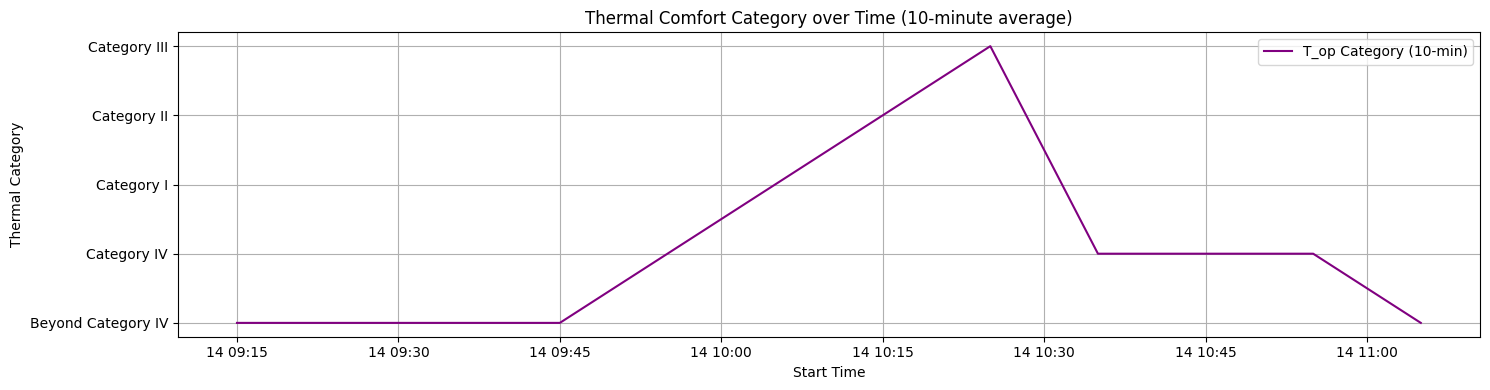

In [27]:
# T_op category vs time (10 min)
plt.figure(figsize=(15, 4))
plt.plot(df_10min["Start Time"], T_op_category_10min, label="T_op Category (10-min)", color="purple")
plt.xlabel("Start Time")
plt.ylabel("Thermal Category")
plt.title("Thermal Comfort Category over Time (10-minute average)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

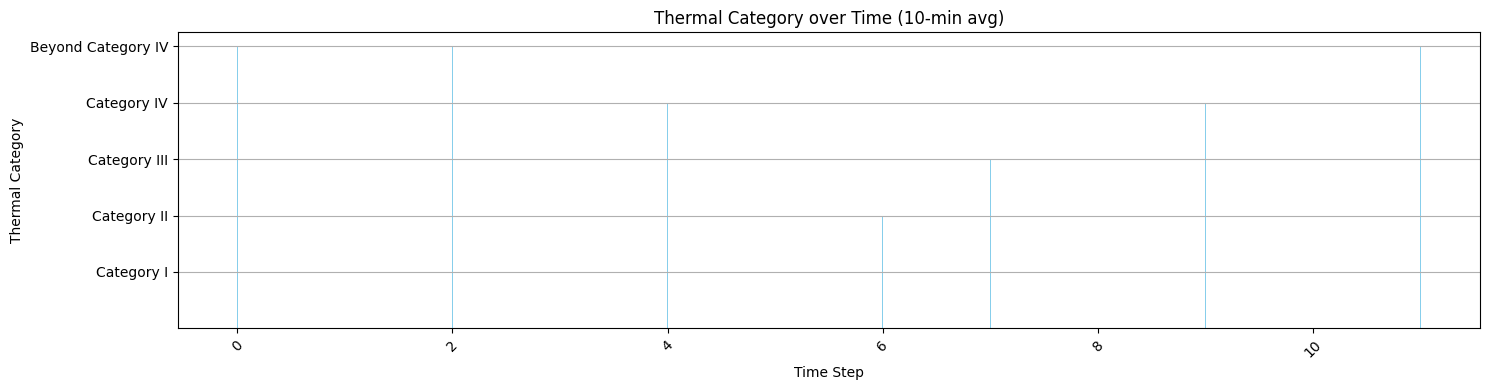

In [148]:
# bar chart plot
# Optional: Assign a numeric code to each category for plotting
category_mapping = {
    "Category I": 1,
    "Category II": 2,
    "Category III": 3,
    "Category IV": 4,
    "Beyond Category IV": 5
}
# Map categories to numbers
category_codes = T_op_category_10min.map(category_mapping)

plt.figure(figsize=(15, 4))
plt.bar(df_10min["Time Step"], category_codes, width=0.005, align='center', color='skyblue')
plt.xlabel("Time Step")
plt.ylabel("Thermal Category")
plt.title("Thermal Category over Time (10-min avg)")
plt.yticks(list(category_mapping.values()), list(category_mapping.keys()))  # Show labels instead of numbers
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

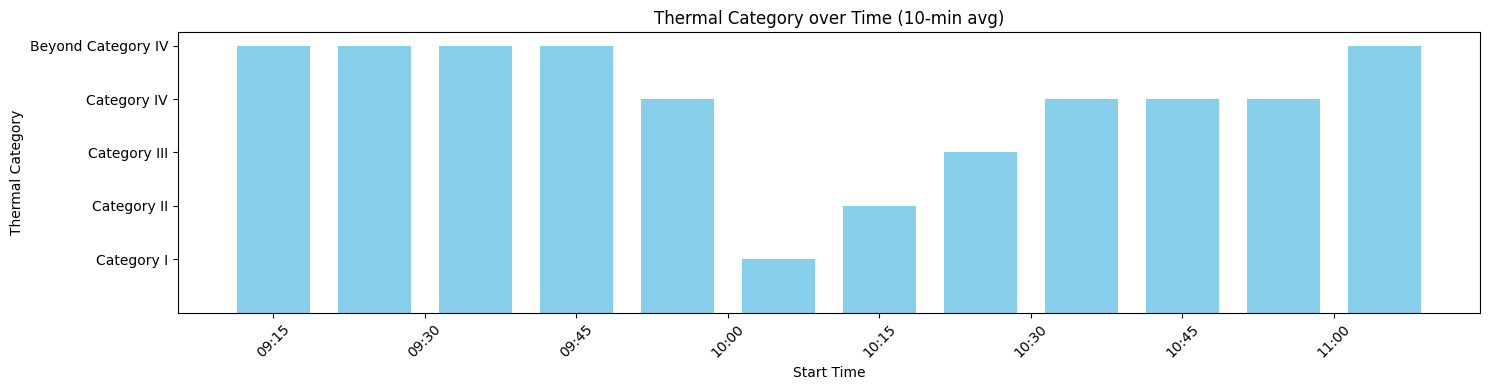

In [150]:
# fixing the 14 in the x axis: 
fig, ax = plt.subplots(figsize=(15, 4))
ax.bar(df_10min["Start Time"], category_codes, width=0.005, align='center', color='skyblue')

# Fix y-axis
ax.set_yticks(list(category_mapping.values()))
ax.set_yticklabels(list(category_mapping.keys()))

# Fix x-axis date format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax.set_xlabel("Start Time")
ax.set_ylabel("Thermal Category")
ax.set_title("Thermal Category over Time (10-min avg)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [119]:
print(df_10min["Start Time"], category_codes )

0    2025-03-14 09:15:00
1    2025-03-14 09:25:00
2    2025-03-14 09:35:00
3    2025-03-14 09:45:00
4    2025-03-14 09:55:00
5    2025-03-14 10:05:00
6    2025-03-14 10:15:00
7    2025-03-14 10:25:00
8    2025-03-14 10:35:00
9    2025-03-14 10:45:00
10   2025-03-14 10:55:00
11   2025-03-14 11:05:00
Name: Start Time, dtype: datetime64[ns] 0     5
1     5
2     5
3     5
4     4
5     1
6     2
7     3
8     4
9     4
10    4
11    5
Name: T_op, dtype: int64
